In [1]:
!pip install torch torchvision matplotlib pillow tqdm scikit-learn



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image


In [1]:
train_dir = r"data\train"
val_dir   = r"data\validation"
test_dir  = r"data\test-sample"


In [6]:
import os

print("Train exists:", os.path.exists(train_dir))
print("Validation exists:", os.path.exists(val_dir))
print("Test exists:", os.path.exists(test_dir))


Train exists: True
Validation exists: True
Test exists: True


In [8]:
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

transform_val = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(train_dir, transform=transform_train)
val_ds   = datasets.ImageFolder(val_dir,   transform=transform_val)
test_ds  = datasets.ImageFolder(test_dir,  transform=transform_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)


Classes: ['captain-america', 'hulk', 'iron-man', 'thor']


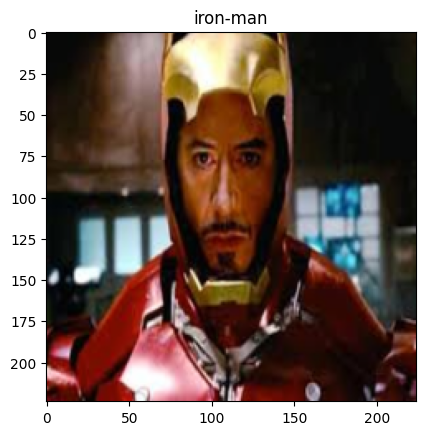

In [9]:
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.show()

# show a batch
inputs, labels = next(iter(train_loader))
imshow(inputs[0], title=classes[labels[0]])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


d:\Code\marvel_imageclassifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Code\marvel_imageclassifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\RUSHIKESH/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:01<00:00, 28.2MB/s]


In [11]:
def train_model(model, train_loader, val_loader, epochs=5):
    best_acc = 0.0
    history = {"train_loss": [], "val_acc": []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * imgs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        
        # validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_acc = correct / total
        history["train_loss"].append(epoch_loss)
        history["val_acc"].append(val_acc)
        
        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Val Acc={val_acc:.4f}")
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({'model_state_dict': model.state_dict(), 'classes': classes}, "marvel_resnet18.pth")
            print("✅ Saved best model")
    
    return history

history = train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10: 100%|██████████| 44/44 [02:42<00:00,  3.68s/it]


Epoch 1: Loss=0.3704, Val Acc=0.9500
✅ Saved best model


Epoch 2/10: 100%|██████████| 44/44 [02:18<00:00,  3.15s/it]


Epoch 2: Loss=0.0511, Val Acc=0.9500


Epoch 3/10: 100%|██████████| 44/44 [02:23<00:00,  3.26s/it]


Epoch 3: Loss=0.0356, Val Acc=0.9650
✅ Saved best model


Epoch 4/10: 100%|██████████| 44/44 [02:25<00:00,  3.30s/it]


Epoch 4: Loss=0.0122, Val Acc=0.9750
✅ Saved best model


Epoch 5/10: 100%|██████████| 44/44 [02:27<00:00,  3.35s/it]


Epoch 5: Loss=0.0098, Val Acc=0.9800
✅ Saved best model


Epoch 6/10: 100%|██████████| 44/44 [02:27<00:00,  3.35s/it]


Epoch 6: Loss=0.0065, Val Acc=0.9650


Epoch 7/10: 100%|██████████| 44/44 [02:27<00:00,  3.34s/it]


Epoch 7: Loss=0.0058, Val Acc=0.9850
✅ Saved best model


Epoch 8/10: 100%|██████████| 44/44 [02:24<00:00,  3.29s/it]


Epoch 8: Loss=0.0080, Val Acc=0.9750


Epoch 9/10: 100%|██████████| 44/44 [02:15<00:00,  3.08s/it]


Epoch 9: Loss=0.0047, Val Acc=0.9700


Epoch 10/10: 100%|██████████| 44/44 [02:16<00:00,  3.09s/it]


Epoch 10: Loss=0.0021, Val Acc=0.9750


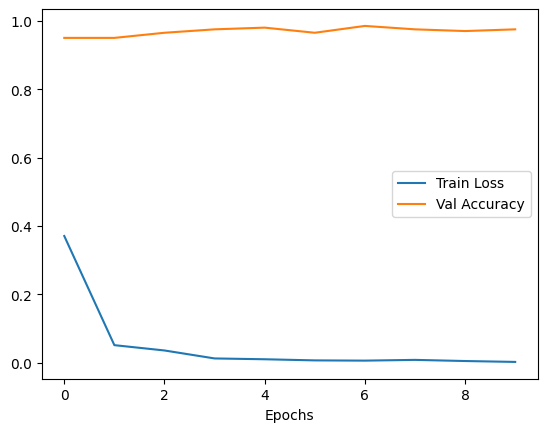

In [12]:
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [13]:
checkpoint = torch.load("marvel_resnet18.pth", map_location=device)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

correct = 0
for img, label in test_loader:
    img, label = img.to(device), label.to(device)
    with torch.no_grad():
        out = model(img)
        pred = torch.argmax(out, 1)
    if pred == label:
        correct += 1
print(f"Test Accuracy: {correct}/{len(test_ds)} = {correct/len(test_ds):.2f}")


Test Accuracy: 11/12 = 0.92


In [15]:
def predict(img_path):
    image = Image.open(img_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
    ])
    x = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        out = model(x)
        probs = torch.nn.functional.softmax(out, dim=1)[0]
        pred_idx = torch.argmax(probs).item()
    return classes[pred_idx], probs[pred_idx].item()

# Example
print(predict("data/test-sample/iron-man/iron-man_2.jpg"))


('iron-man', 0.9999510049819946)


In [18]:
import torch
from torchvision import datasets, transforms

train_dir = r"data/train"
val_dir = r"data/validation"
test_dir = r"data/test-sample"

# Image transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


In [19]:
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_resnet = models.resnet18(pretrained=True)
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, len(train_dataset.classes))
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

# Training loop (simplified)
epochs = 5
for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


d:\Code\marvel_imageclassifier\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Code\marvel_imageclassifier\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Loss: 0.4984
Epoch 2, Loss: 0.2422
Epoch 3, Loss: 0.1632
Epoch 4, Loss: 0.1000
Epoch 5, Loss: 0.1055


In [20]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))

print("ResNet18 Evaluation:")
evaluate_model(model_resnet, val_loader)


ResNet18 Evaluation:
Accuracy: 0.9250
                 precision    recall  f1-score   support

captain-america       0.95      0.84      0.89        50
           hulk       0.98      0.98      0.98        50
       iron-man       1.00      0.88      0.94        50
           thor       0.81      1.00      0.89        50

       accuracy                           0.93       200
      macro avg       0.94      0.92      0.93       200
   weighted avg       0.94      0.93      0.93       200



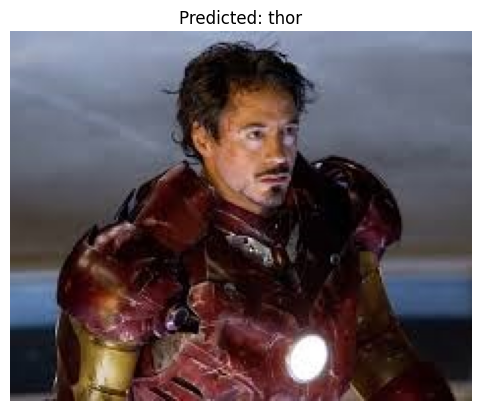

In [28]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    model.eval()
    image = Image.open(image_path)
    transform = val_transforms
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image_tensor)
        pred = output.argmax(dim=1).item()
    plt.imshow(image)
    plt.title(f"Predicted: {train_dataset.classes[pred]}")
    plt.axis('off')
    plt.show()

# Example
predict_image(model_resnet, r"data/test-sample/iron-man/iron-man_3.jpg")


import os
from torchvision import datasets, transforms

# Paths
train_dir = r"data/train"
val_dir   = r"data/validation"
test_dir  = r"data/test-sample"

# Transformation (resize + convert to tensor)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Try loading datasets
try:
    train_dataset = datasets.ImageFolder(train_dir, transform=transform)
    val_dataset   = datasets.ImageFolder(val_dir, transform=transform)
    test_dataset  = datasets.ImageFolder(test_dir, transform=transform)

    print("✅ Train classes:", train_dataset.classes)
    print("✅ Validation classes:", val_dataset.classes)
    print("✅ Test classes:", test_dataset.classes)
    print("Everything looks good! 🚀")

except Exception as e:
    print("❌ Error:", e)


In [34]:
import torch

# after training
torch.save(model_resnet.state_dict(), r"D:\Code\marvel_imageclassifier\models\resnet18_marvel.pth")



# Optionally, save class names
with open("data/class_names.txt", "w") as f:
    for cls in train_dataset.classes:
        f.write(f"{cls}\n")


RuntimeError: Parent directory D:\Code\marvel_imageclassifier\models does not exist.